# Setup & Data loading

In [37]:
# imports
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import backend as K

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [38]:
df = pd.read_csv("data/cleaned/hate_speech_dataset.tsv")
df["cleaned_post"] = df["cleaned_post"].astype(str)

print(df["class"].value_counts())
print(df["bi_class"].value_counts())
print(df["mul_class"].value_counts())

df["binary"] = (df["class"] == "implicit_hate").astype(int)


class
not_hate         13270
implicit_hate     7094
explicit_hate     1086
Name: count, dtype: int64
bi_class
0    13270
1     8180
Name: count, dtype: int64
mul_class
0    13270
1     7094
2     1086
Name: count, dtype: int64


# Train/Test split

In [39]:
X = df["cleaned_post"].values
y = df["binary"].values.astype("int32")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y
)

# Baseline Model: Naive Bayers + TF-IDF


In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)


Naive Bayes (Implicit vs Others) Report:
              precision    recall  f1-score   support

           0     0.7017    0.9659    0.8128      2871
           1     0.7101    0.1691    0.2732      1419

    accuracy                         0.7023      4290
   macro avg     0.7059    0.5675    0.5430      4290
weighted avg     0.7044    0.7023    0.6343      4290



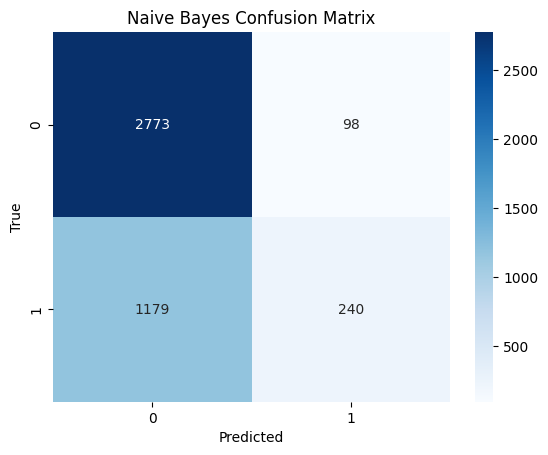

In [41]:
print("Naive Bayes (Implicit vs Others) Report:")
print(classification_report(y_test, y_pred_nb, digits=4))

cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues")
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The Naive Bayes baseline performs well at identifying the majority “other” class, achieving a very high recall of 0.97. However, its performance on implicit hate — the minority class — is extremely weak. Although precision for class 1 is moderate (0.71), recall drops to only 0.17, meaning the model misses more than 80% of implicit hate examples. This indicates that Naive Bayes relies heavily on surface-level lexical cues and cannot capture the subtle, context-dependent patterns that characterize implicit hate. As a result, the model is strongly biased toward predicting the majority class, leading to poor macro-F1 and ineffective minority-class detection.

# Model 2: RNN - LSTM

In [42]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 20000
MAX_LEN = 80

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)


## Model Building

In [43]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

# class weight(for imbalanced data)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: w for i, w in enumerate(class_weights)}




In [44]:
EMBED_DIM = 100
LSTM_UNITS = 64

inputs = Input(shape=(MAX_LEN,))
x = Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM)(inputs)
x = Bidirectional(LSTM(LSTM_UNITS))(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

bilstm_model = Model(inputs, outputs)
bilstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# train without class weight
history_imp_1 = bilstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=[es],
    verbose=1
)
y_prob_1 = bilstm_model.predict(X_test_pad)
y_pred_1 = (y_prob_1 >= 0.5).astype("int32").ravel()


Epoch 1/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.6889 - loss: 0.5936 - val_accuracy: 0.7045 - val_loss: 0.5617
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.7917 - loss: 0.4424 - val_accuracy: 0.7005 - val_loss: 0.6254
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.8627 - loss: 0.3194 - val_accuracy: 0.6742 - val_loss: 0.6961
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [45]:
history_imp_2 = bilstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[es],
    verbose=1
)
y_prob_2 = bilstm_model.predict(X_test_pad)
y_pred_2 = (y_prob_2 >= 0.5).astype("int32").ravel()

Epoch 1/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.7641 - loss: 0.4839 - val_accuracy: 0.6906 - val_loss: 0.6127
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.8304 - loss: 0.3643 - val_accuracy: 0.6492 - val_loss: 0.7550
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


## Training curve

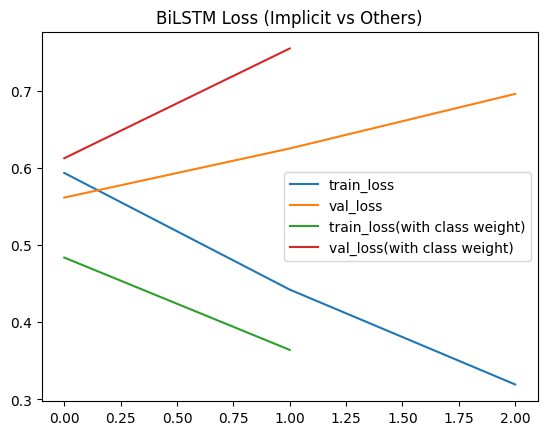

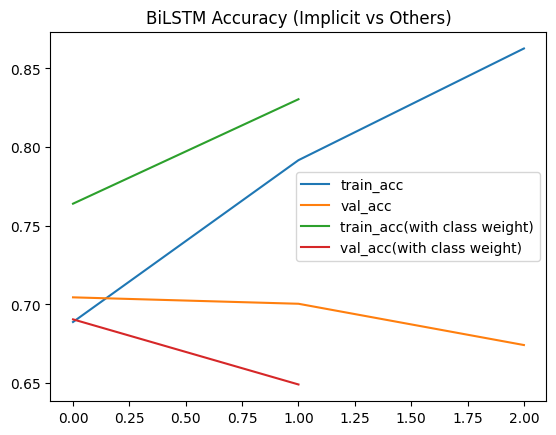

In [46]:
plt.plot(history_imp_1.history['loss'], label='train_loss')
plt.plot(history_imp_1.history['val_loss'], label='val_loss')
plt.plot(history_imp_2.history['loss'], label='train_loss(with class weight)')
plt.plot(history_imp_2.history['val_loss'], label='val_loss(with class weight)')
plt.legend()
plt.title("BiLSTM Loss (Implicit vs Others)")
plt.show()

plt.plot(history_imp_1.history['accuracy'], label='train_acc')
plt.plot(history_imp_1.history['val_accuracy'], label='val_acc')
plt.plot(history_imp_2.history['accuracy'], label='train_acc(with class weight)')
plt.plot(history_imp_2.history['val_accuracy'], label='val_acc(with class weight)')
plt.legend()
plt.title("BiLSTM Accuracy (Implicit vs Others)")
plt.show()


## Evaluation

BiLSTM (Implicit vs Others) Report(without class weight):
              precision    recall  f1-score   support

           0     0.7315    0.9080    0.8103      2871
           1     0.6364    0.3256    0.4308      1419

    accuracy                         0.7154      4290
   macro avg     0.6839    0.6168    0.6205      4290
weighted avg     0.7000    0.7154    0.6847      4290



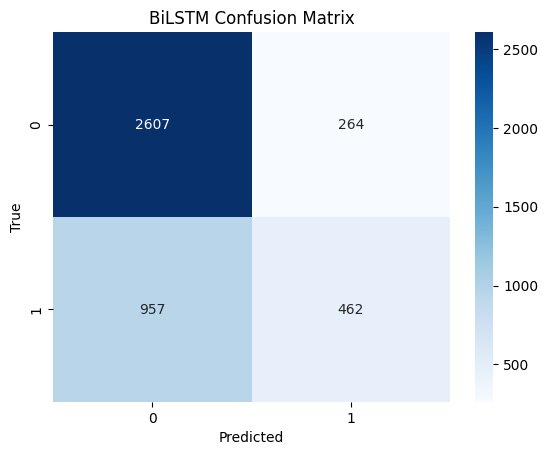

In [47]:
print("BiLSTM (Implicit vs Others) Report(without class weight):")
print(classification_report(y_test, y_pred_1, digits=4))

cm_imp = confusion_matrix(y_test, y_pred_1)
sns.heatmap(cm_imp, annot=True, fmt="d", cmap="Blues")
plt.title("BiLSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


BiLSTM (Implicit vs Others) Report(with class weight):
              precision    recall  f1-score   support

           0     0.7542    0.7962    0.7747      2871
           1     0.5353    0.4750    0.5034      1419

    accuracy                         0.6900      4290
   macro avg     0.6448    0.6356    0.6390      4290
weighted avg     0.6818    0.6900    0.6849      4290



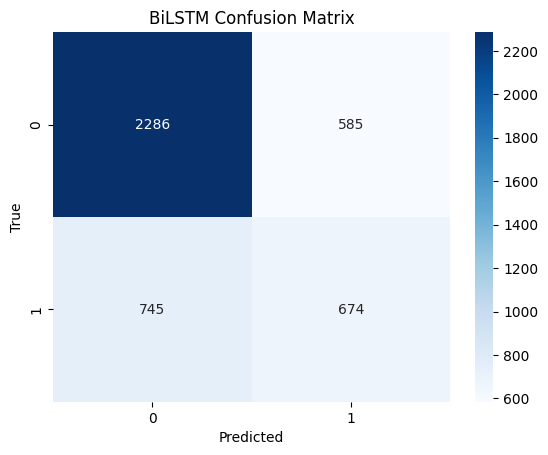

In [48]:
print("BiLSTM (Implicit vs Others) Report(with class weight):")
print(classification_report(y_test, y_pred_2, digits=4))

cm_imp = confusion_matrix(y_test, y_pred_2)
sns.heatmap(cm_imp, annot=True, fmt="d", cmap="Blues")
plt.title("BiLSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Applying class weights improves the model’s ability to detect implicit hate — the minority class — by substantially increasing recall (from 0.33 to 0.48) and improving the F1 score for class 1. This indicates that the baseline model was strongly biased toward the majority “other” class, and class weighting helps correct this imbalance by encouraging the network to pay more attention to subtle hateful content.

The overall accuracy drops slightly, which is expected: increasing sensitivity to minority samples comes at the cost of misclassifying more majority-class examples. However, for this task, detecting implicit hate is more important than optimizing global accuracy.

In summary, class weighting provides a meaningful but limited improvement — a step in the right direction, but insufficient on its own. The task remains challenging, and more advanced models (e.g., BERT) are likely required to capture deeper contextual cues.

Possible Reasons:

1. Implicit hate rarely contains explicit lexical cues
2. RNNs struggle with long-range or abstract semantic dependencies
3. Data imbalance amplifies RNN weaknesses
4. Vocabulary-based sequence models cannot detect paraphrasing or contextual shifts
5. Overfitting occurs easily due to small dataset + high model capacity